<br>

# Prepare Training And Test Data

In the previous notebook, a dataset was curated and cleaned.  The dataset will be used in this notebook to explore and gather more insight in order to create and prepare the training and test data that will be used in the subsequent 'Jupyter' notebook to run our first model.

<br>

In [48]:
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 3rd-part library for managing imbalanced data.
from imblearn.under_sampling import RandomUnderSampler

from IPython.core.interactiveshell import InteractiveShell

In [3]:
%matplotlib inline

# Set dataframe options to keep long data in columns from being truncated with ellipsis (...)
pd.set_option('max_colwidth', None)

# Set dataframe options to force display max columns
pd.set_option('display.max_columns', 90)
pd.set_option('display.max_rows', 90)

InteractiveShell.ast_node_interactivity = "all"

Helper functions used throughout this notebook.

In [4]:
def create_dataframe(file_path):
    '''
    Create a pandas dataframe from a JSON file indicated by the parameter file_path
    '''
    with open(file_path, encoding="utf8") as f:
        data = [json.loads(jsonObj) for jsonObj in f]
        
    return pd.DataFrame(data)


def df_info(df):
    '''
    A helper function - similar in functionality with `df.info()` but includes combined features: df.columns, df.dtypes, 
    df.isnull(), df.info(), df.nunique()
    '''
    print('\nShape : {}'.format(df.shape))
    print('Number of duplicates : {}\n'.format(df.duplicated().sum()))

    print('{:^35} {:^12} {:^12} {:^8} {:>10}\n'.format('COLUMNS', 'DATA TYPE', 'HAS NULL', 'COUNTS', '# UNIQUE'))
    for i, v in enumerate(df.columns):
        col = df[v]
        dtype = type(col.iloc[0]).__name__
        
        if dtype=='dict':
            keys = set([item for val in col.values if val is not None for item in list(val.keys())])
            col_nunique = len(keys)
        else:
            col_nunique = col.nunique()
        
        print(' {:>2}.  {:<30} {:<12} {:^10} {:>8} {:>10}'.format(i+1, v, dtype, \
                                                                  str(col.isnull().any()), col.count(), \
                                                                  col_nunique))    # col.nunique()

In [5]:
reviews_dataset = pd.read_csv('../yelp_dataset/reviews_dataset.csv')
df_info(reviews_dataset)


Shape : (4719873, 2)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  text                           str            False     4719873    4719873
  2.  sentiment                      int64          False     4719873          3


### Imbalanced Data

In the previous notebook, an imbalanced number of sentiments was observed.

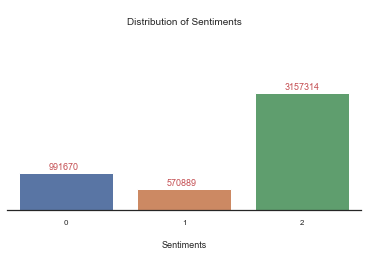

In [6]:
sns.set(style="white")
params = {'axes.spines.top':False, 'axes.spines.right': False, 'axes.spines.left': False, 
          'axes.labelsize' : 9, 'xtick.labelsize' : 8, 'ytick.labelsize' : 8}
matplotlib.rcParams.update(params)
fig = plt.figure(constrained_layout=True, figsize=(5, 2.4))
ax = fig.gca()
sns.countplot(reviews_dataset.sentiment, ax=ax)

counts=reviews_dataset.groupby('sentiment').count().text
for i, txt in enumerate(ax.get_xticklabels()):
    count = counts[int(txt.get_text())]
    ax.text(i-.15, count+100000, '{}'.format(count), fontdict={'fontsize': 9}, c='r')

ax.set_xlabel('\nSentiments')
ax.yaxis.set_visible(False)
fig.suptitle('\nDistribution of Sentiments', y=1.42, fontsize=10);
ax.set_xticklabels(labels=[lbl.get_text().title() for lbl in ax.get_xticklabels()]);

> Having an imbalanced data impacts the model so its important to balance the data that will be used to train the model.

There are 2 ways to approach this:

`1.` Under-sample (reduce) the dataset so that the negative, neutral, and positive sentiments have an equal number of instances.  Since the least number of sentiment is neutral with `570,889` instances, this would mean reducing the dataset from `4,719,873` down to `1,712,667` (`570,889` x 3).  

`2.` Keep the imbalance but assign appropriate class weights during `model.fit` so that the negative and neutral sentiments will be treated equally with the positive sentiments.  This way no data is discarded however the disadvantage of doing this is that a much substantial amount of data will be used for training, approximately `3,303,911` instances (70% of the dataset) which would slow down the training time and as a result may limit the number of epochs for training.

These two options will be tried and result will be observed.

In [23]:
# RandomUnderSampler is used from the imblearn using the sampling-strategy auto
rus = RandomUnderSampler(sampling_strategy='auto')

X = reviews_dataset[['text']]
y = reviews_dataset['sentiment']

X_rus, y_rus = rus.fit_resample(X, y)

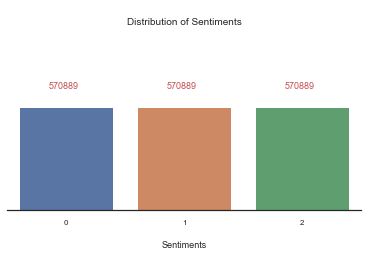

In [32]:
sns.set(style="white")
params = {'axes.spines.top':False, 'axes.spines.right': False, 'axes.spines.left': False, 
          'axes.labelsize' : 9, 'xtick.labelsize' : 8, 'ytick.labelsize' : 8}
matplotlib.rcParams.update(params)
fig = plt.figure(constrained_layout=True, figsize=(5, 2.4))
ax = fig.gca()
sns.countplot(y_rus, ax=ax)
counts=y_rus.groupby(y_rus).count()
for i, txt in enumerate(ax.get_xticklabels()):
    count = counts[int(txt.get_text())]
    ax.text(i-.15, count+100000, '{}'.format(count), fontdict={'fontsize': 9}, c='r')

ax.set_xlabel('\nSentiments')
ax.yaxis.set_visible(False)
fig.suptitle('\nDistribution of Sentiments', y=1.42, fontsize=10);
ax.set_xticklabels(labels=[lbl.get_text().title() for lbl in ax.get_xticklabels()]);

In [49]:
review_lengths = [len(x[0].split()) for x in X_rus.values]

# plot lenghts of reviews
x=pd.Series(np.array(review_lengths))

# IQR
IQR = x.describe()['75%'] - x.describe()['25%']

# IQR multiplier to set the whisker/boundary for outliers (default is 1.5)
IQR_multiplier = 1.5

# Defining threshold as the 3rd Quartile + (IQR * IQR_multiplier)
outlier_threshold = math.floor(x.describe()['75%'] + (IQR*IQR_multiplier))

print('\nStatistically accepted boundary for outliers : {}\n'.format(outlier_threshold))


Statistically accepted boundary for outliers : 300



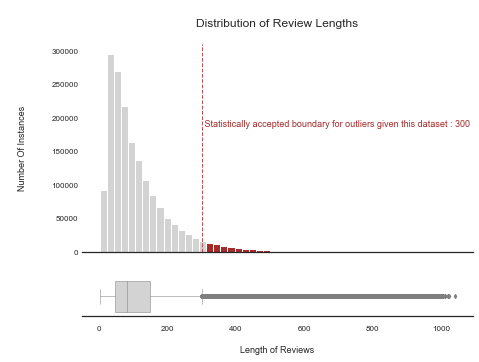

In [56]:
params = {'axes.titlesize':'9', 'xtick.labelsize':'8', 'ytick.labelsize':'8', 'axes.spines.top':False,
          'axes.spines.right': False}
matplotlib.rcParams.update(params)
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .15)})
tmp = ax_hist.set_title('\nDistribution of Review Lengths\n', fontdict={'fontsize': 12});
tmp = ax_hist.set_ylabel('\nNumber Of Instances\n\n', fontdict={'fontsize': 9})
ax_hist.tick_params(bottom="off", length=0)
tmp = ax_hist.axvline(x=outlier_threshold, c='r', linestyle='--', linewidth=1)
text = ' Statistically accepted boundary for outliers given this dataset : {}\n'
tmp = ax_hist.annotate(text.format(int(outlier_threshold)), (outlier_threshold+1, x.count()/10), fontsize=9, color='brown')
ax_box.spines['left'].set_visible(False)
ax_box.yaxis.set_visible(False)

res = x.hist(figsize=(7, 5), color='lightgray', grid=False, ax=ax_hist, bins=50)

for idx, rec in enumerate(res.patches):
    if rec.xy[0] > outlier_threshold-1:
        res.patches[idx].set_fc('brown')  
bx = sns.boxplot(x, ax=ax_box, fliersize=3, color='lightgray', linewidth=.5, whis=IQR_multiplier)
tmp = ax_box.set_xlabel('\nLength of Reviews', fontdict={'fontsize': 9})
#plt.tight_layout();


In [132]:
short_reviews = []
for r in X_rus.iterrows():
    
    if len(r[1][0].split()) > 1000:
        short_reviews.append(r[1][0])

In [133]:
print(len(short_reviews))
sr = pd.Series(short_reviews)

16


In [140]:
sr.sample(1)

9    If I could give this place no stars I would, from the initial time of entering into the hotel your overwhelmed with a mixture of smells - crazy strong perfume they must pump into the vents to cover up the smell of rotten eggs and sewage- this is NOT the ideal place for an asthmatic! Never had a problem the hotels in vegas even though there is smoking in there. Up until this point it's me just walking in, then waited in line to get to the front and ended up having to wait for a the girl to get a manager because she had no clue what she was doing on the other end of the computer. After the manager came he told us there is a 300$ fee put on my card for a security deposit ($100 a night)  after that we headed up to our room after traveling and being exhausted but yet ecstatic to be in vegas away from the cold in Chicago - we walk into this room which is extremely comparable to a hostel. The room was the ugly yellow color tile with mirrors hiding the toilet and the shower. The bed is pl